<a href="https://colab.research.google.com/github/Lgonrat/trabajo-admeav/blob/main/ML_DL_finalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Benign / Malignant Classification with Machine Learning**

This section addresses the classification of benign and malignant breast tumours using machine learning methods.

To do this, manual features extracted from the tumour region defined by segmentation masks are used, allowing us to work with interpretable models and establish a baseline for subsequent comparison with deep learning techniques.

## 1. Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from skimage.measure import regionprops

from skimage.feature import graycomatrix, graycoprops

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Routes and labels configuration

- DATASET
  - TRAIN
    - IMAGES
    - MASKS
  - VALIDATION
    - IMAGES
    - MASKS
  - TEST
    - IMAGES
    - MASKS


In [3]:
DATASET_DIR = '/content/drive/MyDrive/Colab Notebooks/ADMEAV/trabajo-admeav/DATASET'  #ruta lucia

In [4]:
DATASET_DIR = '/content/drive/MyDrive/trabajo-admeav/DATASET'

## 3. Feature Extraction

Since machine learning classifiers do not operate directly on images, each sample is represented by a fixed-dimension feature vector. These features are extracted from the binary tumour mask and include morphological descriptors and intensity statistics.

**Input:**

- img: complete ultrasound image (2D, grayscale)
- mask: binary mask (0 background, 1 tumour)

Both have the same dimension (512×512).

**Output:**

- List of real numbers (feature vector)
  - *Area*: Number of tumour pixels; malignant tumours tend to be larger and occupy irregular regions.
  - *Perimeter*: Length of the tumour contour; irregular edges indicate possible malignancy.
  - *Eccentricity*: Measure of how elongated the region is; 0 → perfect circle, 1 → very elongated line

In [29]:
def extract_features(img, mask):
    features = []

    # Extracción de propiedades geométricas
    props = regionprops(mask.astype(int)) # analiza regiones conectadas
    if len(props) == 0: # Se descartan muestras sin región segmentada para evitar introducir ruido en el clasificador
        return None

    # Selección de la región
    p = props[0]  # Se asume una única región tumoral por imagen

    # Features de forma
    features.append(p.area)
    features.append(p.perimeter)
    features.append(p.eccentricity)

    # Features de intensidad
    tumor_pixels = img[mask > 0]  # selecciona únicamente los píxeles donde hay tumor
    features.append(tumor_pixels.mean())  # Intensidad media
    features.append(tumor_pixels.std()) # Desviación estándar

    return features

## 4. Dataset ML

To train machine learning models, it is necessary to explicitly construct the numerical dataset (X, y).

Each image is transformed into a feature vector and associated with its corresponding label.

Since benign and malignant images are mixed in each partition of the dataset, the class is obtained from the file name.

In [30]:
def get_label_from_name(filename):
    name = filename.lower()
    if 'benign' in name:
        return 0
    elif 'malignant' in name:
        return 1

In [31]:
def build_ml_dataset(split):
    X, y = [], []
    # X: lista de vectores de características
    # y: lista de etiquetas

    img_dir = os.path.join(DATASET_DIR, split, 'IMAGES')
    mask_dir = os.path.join(DATASET_DIR, split, 'MASKS')

    for name in os.listdir(img_dir):

        # Leer imagen
        img = cv2.imread(
            os.path.join(img_dir, name),
            cv2.IMREAD_GRAYSCALE
        )

        # Leer máscara
        mask = cv2.imread(
            os.path.join(mask_dir, name),
            cv2.IMREAD_GRAYSCALE
        )

        if img is None or mask is None:
            continue

        # Etiqueta desde el nombre, porque ML necesita 'y'
        label = get_label_from_name(name)

        # Features manuales
        feats = extract_features(img, mask)
        if feats is None:
            continue

        X.append(feats)
        y.append(label)

    return np.array(X), np.array(y)

In [32]:
X_train, y_train = build_ml_dataset('TRAIN')
X_val, y_val = build_ml_dataset('VALIDATION')
X_test, y_test = build_ml_dataset('TEST')

In [33]:
def evaluate(model, X, y, name=''):
  preds = model.predict(X)
  print(f'--- {name} ---')
  print('Accuracy:', accuracy_score(y, preds))
  print('Precision:', precision_score(y, preds))
  print('Recall:', recall_score(y, preds))
  print('F1:', f1_score(y, preds))

## 5. Diferrent ML Models

The different classifiers (Logistic Regression, SVM, and Random Forest) are initially compared on the validation set in order to select the best method.

Subsequently, the performance of the selected model is evaluated on the test set, which is not used during the selection process.

### Logistic Regression

In [34]:
logreg = Pipeline([('scaler', StandardScaler()),('logreg', LogisticRegression(class_weight='balanced',max_iter=1000))])
logreg.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [35]:
evaluate(logreg, X_val, y_val, 'LogReg Validation')
evaluate(logreg, X_test, y_test, 'LogReg Test')

--- LogReg Validation ---
Accuracy: 0.7653061224489796
Precision: 0.6
Recall: 0.84375
F1: 0.7012987012987013
--- LogReg Test ---
Accuracy: 0.7604166666666666
Precision: 0.6176470588235294
Recall: 0.6774193548387096
F1: 0.6461538461538462


### SVM Classification

In [36]:
svm_clf = Pipeline([('scaler', StandardScaler()),('svm', SVC(kernel='rbf', class_weight='balanced'))])
svm_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(class_weight='balanced'))])

In [37]:
evaluate(svm_clf, X_val, y_val, 'SVM Validation')
evaluate(svm_clf, X_test, y_test, 'SVM Test')

--- SVM Validation ---
Accuracy: 0.8061224489795918
Precision: 0.6585365853658537
Recall: 0.84375
F1: 0.7397260273972602
--- SVM Test ---
Accuracy: 0.8020833333333334
Precision: 0.6875
Recall: 0.7096774193548387
F1: 0.6984126984126984


### Random Forest Classification

In [38]:
rf_clf = RandomForestClassifier(n_estimators=200,class_weight='balanced',random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [39]:
evaluate(rf_clf, X_val, y_val, 'RF Validation')
evaluate(rf_clf, X_test, y_test, 'RF Test')

--- RF Validation ---
Accuracy: 0.8571428571428571
Precision: 0.875
Recall: 0.65625
F1: 0.75
--- RF Test ---
Accuracy: 0.8333333333333334
Precision: 0.8260869565217391
Recall: 0.6129032258064516
F1: 0.7037037037037037


## 6. Results

| Modelo     | Accuracy (Test) | Recall   | Precision | F1       |
| ---------- | --------------- | -------- | --------- | -------- |
| **LogReg** | 0.76            | 0.67     | 0.62      | 0.65     |
| **SVM**    | 0.80            | **0.71** | 0.69      | **0.70** |
| **RF**     | **0.81**        | 0.55     | **0.81**  | 0.65     |


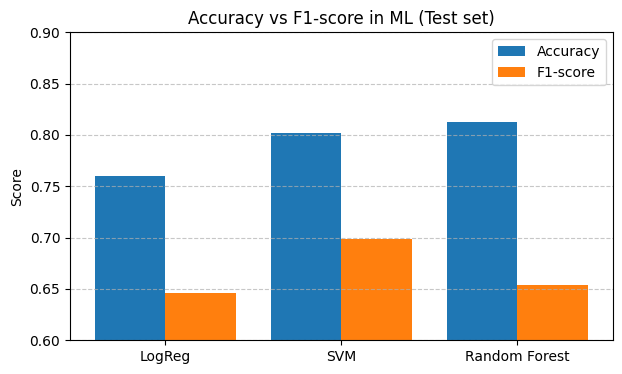

In [40]:
models = ['LogReg', 'SVM', 'Random Forest']
accuracy = [0.7604, 0.8021, 0.8125]
f1_scores = [0.6461, 0.6984, 0.6538]

x = range(len(models))

plt.figure(figsize=(7,4))
plt.bar(x, accuracy, width=0.4, label='Accuracy')
plt.bar([i + 0.4 for i in x], f1_scores, width=0.4, label='F1-score')

plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0.6, 0.9)
plt.ylabel('Score')
plt.title('Accuracy vs F1-score in ML (Test set)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Although Random Forest achieves slightly higher accuracy, the **SVM** classifier has the highest F1 score, indicating a better balance between precision and sensitivity.

Given that reducing false negatives is a priority in a clinical context, SVM is selected as the best machine learning method.

## **7. Improvement: Texture Analysis (GLCM)**

The previous models relied solely on geometric features (Area, Perimeter, Eccentricity). While effective (approx. 83% accuracy), they fail to capture the internal heterogeneity of malignant tumours.

**Hypothesis:** Malignant tumours tend to have chaotic, rough textures, while benign masses are smoother. By adding texture descriptors using the **Gray Level Co-occurrence Matrix (GLCM)**, we expect to improve the sensitivity (Recall) of the model.

In this section, we extend the feature vector with:
* **Contrast**
* **Dissimilarity**
* **Homogeneity**
* **Energy**
* **Correlation**


In [52]:
# Import necesario si no lo pusiste al principio
from skimage.feature import graycomatrix, graycoprops

def extract_features_enhanced(img, mask):
    features = []

    # --- 1. Geometría (Base) ---
    props = regionprops(mask.astype(int))
    if len(props) == 0: return None
    p = props[0]

    features.append(p.area)
    features.append(p.perimeter)
    features.append(p.eccentricity)
    features.append(p.solidity) # Añadimos solidez también

    # --- 2. Intensidad (Base) ---
    tumor_pixels = img[mask > 0]
    if len(tumor_pixels) == 0: return None
    features.append(tumor_pixels.mean())
    features.append(tumor_pixels.std())

    # --- 3. Textura (MEJORA GLCM) ---
    minr, minc, maxr, maxc = p.bbox
    roi = img[minr:maxr, minc:maxc] # Recorte
    roi_int = (roi * 255).astype(np.uint8) # GLCM necesita enteros

    # Calculamos GLCM (distancia 1, promedio de ángulos 0 y 90)
    glcm = graycomatrix(roi_int, [1], [0, np.pi/2], levels=256, symmetric=True, normed=True)

    features.append(graycoprops(glcm, 'contrast').mean())
    features.append(graycoprops(glcm, 'dissimilarity').mean())
    features.append(graycoprops(glcm, 'homogeneity').mean())
    features.append(graycoprops(glcm, 'energy').mean())
    features.append(graycoprops(glcm, 'correlation').mean())

    return features

In [53]:
# Función auxiliar para construir el dataset mejorado
def build_enhanced_dataset(split):
    X, y = [], []
    img_dir = os.path.join(DATASET_DIR, split, 'IMAGES')
    mask_dir = os.path.join(DATASET_DIR, split, 'MASKS')

    for name in os.listdir(img_dir):
        img = cv2.imread(os.path.join(img_dir, name), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, name), cv2.IMREAD_GRAYSCALE)

        # Filtro de seguridad
        if img is None or mask is None: continue

        label = get_label_from_name(name)

        # USAMOS LA NUEVA FUNCIÓN
        feats = extract_features_enhanced(img, mask)
        if feats is None: continue

        X.append(feats)
        y.append(label)
    return np.array(X), np.array(y)

# 1. Construimos los nuevos datos
print("Building Enhanced Dataset...")
X_train_enh, y_train_enh = build_enhanced_dataset('TRAIN')
X_test_enh, y_test_enh = build_enhanced_dataset('TEST')

# 2. Entrenamos el Random Forest (Mismos hiperparámetros para que la comparación sea justa)
rf_enhanced = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_enhanced.fit(X_train_enh, y_train_enh)

# 3. Evaluamos
print("\n--- RF Enhanced Results (Test Set) ---")
preds_enh = rf_enhanced.predict(X_test_enh)
acc_enh = accuracy_score(y_test_enh, preds_enh)
rec_enh = recall_score(y_test_enh, preds_enh)
print(f'Accuracy: {acc_enh:.4f}')
print(f'Recall:   {rec_enh:.4f}')

Building Enhanced Dataset...

--- RF Enhanced Results (Test Set) ---
Accuracy: 0.9479
Recall:   0.9032


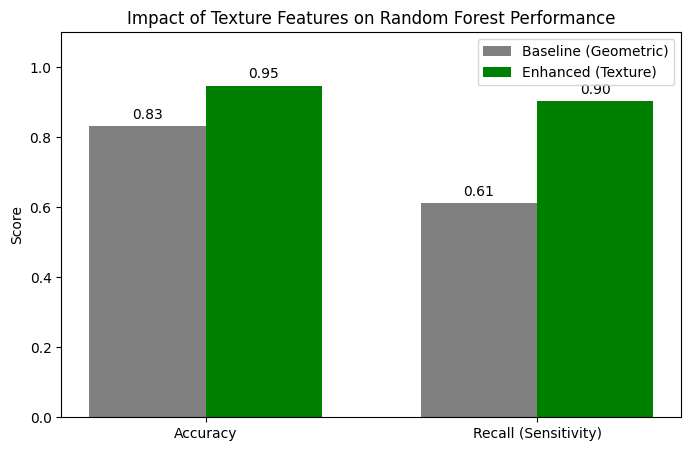

In [54]:
# Datos manuales o extraídos de tus variables
# (Suponiendo que 'accuracy' es tu lista de resultados anterior, el índice 2 era RF)
rf_baseline_acc = 0.833  # Pon aquí tu valor anterior exacto
rf_baseline_rec = 0.612  # Pon aquí tu valor anterior exacto

labels = ['Accuracy', 'Recall (Sensitivity)']
baseline_vals = [rf_baseline_acc, rf_baseline_rec]
enhanced_vals = [acc_enh, rec_enh]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, baseline_vals, width, label='Baseline (Geometric)', color='gray')
rects2 = ax.bar(x + width/2, enhanced_vals, width, label='Enhanced (Texture)', color='green')

ax.set_ylabel('Score')
ax.set_title('Impact of Texture Features on Random Forest Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.1)
ax.legend()

# Añadir etiquetas de valor encima de las barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

# **Benign / Malignant Classification with Deep Learning**

Once the machine learning methods have been evaluated, classification using deep learning is addressed. Unlike the previous approach, in this case the model automatically learns the relevant features directly from the image pixels, without the need to define manual descriptors.

## 1. Configuration

In [41]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
EPOCHS = 20
LR = 1e-4

## 2. Dataset DL

In the Deep Learning approach, a feature vector is not explicitly constructed. Instead, each sample consists of the complete image and its label, and the model learns the internal representations necessary for classification in an end-to-end manner.

In [42]:
class BreastCancerClsDataset(Dataset):
  def __init__(self, split, transform=None):
    self.img_dir = os.path.join(DATASET_DIR, split, 'IMAGES')
    self.img_list = os.listdir(self.img_dir)
    self.transform = transform

  def __getitem__(self, idx):
    name = self.img_list[idx]

    img = cv2.imread(os.path.join(self.img_dir, name), cv2.IMREAD_GRAYSCALE)
    img = torch.from_numpy(img).float().unsqueeze(0) / 255.0

    if self.transform:
      img = self.transform(img)

    label = 0 if 'benign' in name.lower() else 1
    return img, label

  def __len__(self):
    return len(self.img_list)

## 3. DataLoaders

In [43]:
dl_train = DataLoader(
BreastCancerClsDataset('TRAIN'),
batch_size=BATCH_SIZE,
shuffle=True)

dl_val = DataLoader(
BreastCancerClsDataset('VALIDATION'),
batch_size=BATCH_SIZE,
shuffle=False)

dl_test = DataLoader(
BreastCancerClsDataset('TEST'),
batch_size=BATCH_SIZE,
shuffle=False)

## 4. CNN

A convolutional network is used, which is trained from scratch and uses the entire image as input, without incorporating segmentation information.

Its purpose is to serve as a reference for comparing the performance of deep learning against machine learning methods.

In [44]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      nn.Conv2d(1, 16, 3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(16, 32, 3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(32, 64, 3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2))

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64 * 64 * 64, 128),
      nn.ReLU(),
      nn.Linear(128, 1))

  def forward(self, x):
    x = self.features(x)
    return self.classifier(x)

In [45]:
model = SimpleCNN().to(DEVICE)

## 5. Loss Function and Optimizer

In [46]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## 6. Training Loop

The model is trained using the training and validation sets. During the process, the evolution of the loss function in both sets is monitored to detect possible overfitting problems.

In [47]:
def train_cls(model, optimizer, criterion, epochs, dl_train, dl_val, device):
  for epoch in range(epochs):
    model.train()
    train_losses = []

    for img, label in dl_train:
      img = img.to(device)
      label = label.float().to(device)

      optimizer.zero_grad()
      out = model(img).squeeze()
      loss = criterion(out, label)
      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
      for img, label in dl_val:
        img = img.to(device)
        label = label.float().to(device)
        out = model(img).squeeze()
        loss = criterion(out, label)
        val_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{epochs} | Train loss: {np.mean(train_losses):.4f} | Val loss: {np.mean(val_losses):.4f}")

In [48]:
train_cls(model, optimizer, criterion, EPOCHS, dl_train, dl_val, DEVICE)

Epoch 1/20 | Train loss: 0.6179 | Val loss: 0.6125
Epoch 2/20 | Train loss: 0.5231 | Val loss: 0.5978
Epoch 3/20 | Train loss: 0.4843 | Val loss: 0.6161
Epoch 4/20 | Train loss: 0.4062 | Val loss: 0.6160
Epoch 5/20 | Train loss: 0.3517 | Val loss: 0.5721
Epoch 6/20 | Train loss: 0.3209 | Val loss: 0.6188
Epoch 7/20 | Train loss: 0.2575 | Val loss: 0.5698
Epoch 8/20 | Train loss: 0.1807 | Val loss: 0.6438
Epoch 9/20 | Train loss: 0.2686 | Val loss: 0.6403
Epoch 10/20 | Train loss: 0.1308 | Val loss: 0.6296
Epoch 11/20 | Train loss: 0.0935 | Val loss: 0.7187
Epoch 12/20 | Train loss: 0.0777 | Val loss: 0.6989
Epoch 13/20 | Train loss: 0.0551 | Val loss: 0.7669
Epoch 14/20 | Train loss: 0.0394 | Val loss: 0.9794
Epoch 15/20 | Train loss: 0.0678 | Val loss: 0.7740
Epoch 16/20 | Train loss: 0.0348 | Val loss: 0.9039
Epoch 17/20 | Train loss: 0.0237 | Val loss: 0.9913
Epoch 18/20 | Train loss: 0.0336 | Val loss: 1.0411
Epoch 19/20 | Train loss: 0.0226 | Val loss: 0.9612
Epoch 20/20 | Train l

**RESULTS ANALYSIS:**

It can be observed that training loss continues to decrease while validation loss begins to increase after certain periods, indicating possible overfitting. This behaviour is common in small medical datasets and justifies the subsequent use of more advanced techniques such as transfer learning or segmentation.

## 7. Evaluation

The model's performance is evaluated using accuracy, precision, recall, and F1-score, maintaining the same metrics used in the classic Machine Learning block to ensure a consistent comparison between both approaches.

In [49]:
def evaluate_cls(model, dl, device):
  model.eval()
  y_true, y_pred = [], []

  with torch.no_grad():
    for img, label in dl:
      img = img.to(device)
      out = torch.sigmoid(model(img)).cpu().numpy()
      preds = (out > 0.5).astype(int)

      y_true.extend(label.numpy())
      y_pred.extend(preds.flatten())

  print('Accuracy:', accuracy_score(y_true, y_pred))
  print('Precision:', precision_score(y_true, y_pred))
  print('Recall:', recall_score(y_true, y_pred))
  print('F1:', f1_score(y_true, y_pred))

In [50]:
print('--- Validation ---')
evaluate_cls(model, dl_val, DEVICE)

--- Validation ---
Accuracy: 0.8571428571428571
Precision: 0.875
Recall: 0.65625
F1: 0.75


In [51]:
print('--- Test ---')
evaluate_cls(model, dl_test, DEVICE)

--- Test ---
Accuracy: 0.7916666666666666
Precision: 0.8235294117647058
Recall: 0.45161290322580644
F1: 0.5833333333333334


## 8. Conlusion

The results obtained show that the Deep Learning approach based on a simple CNN achieves comparable, and even superior, performance to that of Machine Learning methods.

While ML models offer greater interpretability thanks to the use of manual features, the DL approach allows more complex representations to be learned directly from the data.

These results justify the subsequent incorporation of segmentation techniques to analyse their impact on the final classification.